# Histograma de puntos visitante
Sara Bengoechea Rodríguez

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz #descomprime el fichero
!pip install -q findspark #instala spark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" #funciones dels sistema de python para cambiar variables de entorno y que funcione
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark #para tener un contexto spark donde trabajar
findspark.init()
from pyspark import SparkContext
sc = SparkContext("local", "First App").getOrCreate()

Cargamos los datos en un rdd

In [2]:
data = sc.textFile("partidosLigaNBA.csv")

Comprobamos el número de elementos

In [3]:
data.count()

12908

Visualizamos las 5 primeras filas

In [4]:
data.take(5)

['Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1',
 'Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74']

Dado que hay una cabecera que no necesitamos, la eliminamos

In [5]:
header_data = data.take(1)[0] #guardamos en header_data el header que queremos eliminar
data_processed = data.filter(lambda x: x != header_data) #creamos una funcion que elimine la cabecera
data_processed.take(5) # con take ejecutamos la función anterior y visualizamos que se ha realizado el cambio

['Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74',
 'Wed, Oct 31, 2007:"8:30 pm":Seattle SuperSonics:103:Denver Nuggets:120']

A continuación aplicamos el método map con una función split en su interior para separar los elementos por ":" para poder trabajar con ellos

In [6]:
data_processed = data.filter(lambda x: x != header_data).map(lambda x: x.split(":")) # Función anterior pero separando por :
data_processed.take(5) # ejecutamos con take

[['Tue, Oct 30, 2007',
  '"7',
  '30 pm"',
  'Utah Jazz',
  '117',
  'Golden State Warriors',
  '96'],
 ['Tue, Oct 30, 2007',
  '"7',
  '30 pm"',
  'Houston Rockets',
  '95',
  'Los Angeles Lakers',
  '93'],
 ['Tue, Oct 30, 2007',
  '"7',
  '00 pm"',
  'Portland Trail Blazers',
  '97',
  'San Antonio Spurs',
  '106'],
 ['Wed, Oct 31, 2007',
  '"8',
  '00 pm"',
  'Dallas Mavericks',
  '92',
  'Cleveland Cavaliers',
  '74'],
 ['Wed, Oct 31, 2007',
  '"8',
  '30 pm"',
  'Seattle SuperSonics',
  '103',
  'Denver Nuggets',
  '120']]

Seleccionamos el elemento del vector generado, que está en formato string y hace referencia a los puntos visitantes y lo transformamos a numérico (int)  y filtramos aquellos casos que no sean

Por línea lo que hacemos es:
- Quitamos header
- Función split para separar por :
- filtramos las observaciones que son dígitos
- Convertimos a numérico (int)

In [7]:
data_processed = data.filter(lambda a: a != header_data) \
                      .map(lambda a: a.split(":")[-1]) \
                      .filter(lambda a_puntos_visitante: a_puntos_visitante.isdigit()) \
                      .map(lambda b_puntos_visitante: int(b_puntos_visitante))

data_processed.take(15) # Con take se ejecuta la función

[96, 93, 106, 74, 120, 119, 101, 112, 104, 102, 106, 80, 99, 95, 101]

Aplicaremos una función map que transforme cada número en uno de los intervalos del histograma (que serán los distintintos cuartiles)

Con las siguientes líneas de código obtenemos los valores de cada cuartil

In [8]:
x = data_processed.collect()

In [9]:
x.sort()

In [10]:
# Los valores inferiores al valor resultante pertenecerán al primer cuartil

x[int(len(x)*.25)]

93

In [11]:
# # Los valores inferiores al valor resultante pertenecerán al segundo cuartil (mediana)

x[int(len(x)*.50)]

101

In [12]:
# Los valores inferiores al valor resultante pertenecerán al tercer cuartil y los superiores al cuarto

x[int(len(x)*.75)]


110

Creamos una función llamada cuartil con la que se obtengan los cuartiles

In [13]:
def cuartil(x):
  if x<=93:
    return 'cuartil 1'
  elif x <=101:
    return 'cuartil 2'
  elif x<=110:
    return 'cuartil 3'
  elif x> 110:
    return 'cuartil 4'


Comprobamos que funciona introduciendo el número 95 y viendo que se asigna al segundo cuartil

In [14]:
cuartil(95)

'cuartil 2'

Creamos una lista con cada cuartil y su frecuencia. El key es el intervalo (cuartil correspondiente) y la frecuencia es el valor valor.

In [16]:
data_processed_cuartil = data.filter(lambda a: a != header_data) \
                      .map(lambda a: a.split(":")[-1]) \
                      .filter(lambda a_puntos_visitante: a_puntos_visitante.isdigit()) \
                      .map(lambda b_puntos_visitante: int(b_puntos_visitante)) \
                      .map(lambda x : (cuartil(x),1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .collect()

Comprobamos que se haya ejecutado

In [17]:
data_processed_cuartil

[('cuartil 2', 3196),
 ('cuartil 1', 3261),
 ('cuartil 3', 3464),
 ('cuartil 4', 2976)]

Ordenamos de manera ascendente

In [18]:
data_processed_cuartil.sort()

In [19]:
data_processed_cuartil

[('cuartil 1', 3261),
 ('cuartil 2', 3196),
 ('cuartil 3', 3464),
 ('cuartil 4', 2976)]

Utilizamos un len para sacar el histograma

In [20]:
import numpy as np
import matplotlib.pyplot as plt

([<matplotlib.axis.YTick at 0x7f9eafe7aa20>,
 <a list of 4 Text major ticklabel objects>)

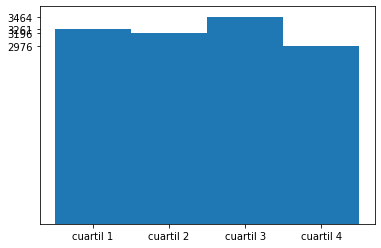

In [21]:
labels, ys = zip(*data_processed_cuartil)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)

Dado que así no se visualiza bien, creamos un diccionario con los 4 cuartiles y usamos plt.bar para visualizarlo de otra manera

In [22]:
dictionary = {'cuartil 1': 3261, 'cuartil 2': 3196, 'cuartil 3': 3464, 'cuartil 4': 2976}

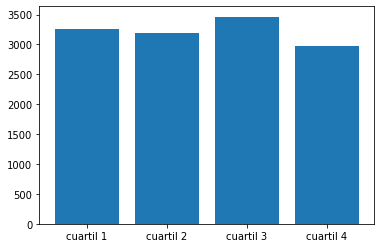

In [23]:
plt.bar(list(dictionary.keys()), dictionary.values())
plt.show()